In [1]:
import cv2
import numpy as np

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

from tqdm import tqdm, trange

from vit import PatchEmbed, MyViTBlock, get_positional_embeddings


In [2]:
class ViT(nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7, hidden_d=16, n_heads=2, n_blocks=2, out_d=2):
        super(ViT, self).__init__()

        self.chw = chw
        self.n_patches = n_patches
        self.hidden_d = hidden_d

        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] // n_patches, chw[2] // n_patches)

        # Patcher and mapper
        self.patcher = PatchEmbed()

        # Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        #  Positional embedding
        self.register_buffer('pos_embed', get_positional_embeddings(
            n_patches ** 2 + 1, hidden_d), persistent=False)

        # Attention blocks
        self.blocks = nn.ModuleList(
            [MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

        # MLP classification
        # self.mlp = nn.Sequential(
        #     nn.Linear(self.hidden_d, out_d),
        #     nn.Softmax(dim=-1)
        # )

    def forward(self, images):
        tokens = self.patcher(images).flatten(1, 2)

        tokens = torch.cat((self.class_token.expand(
            len(tokens), 1, -1), tokens), dim=1)

        # Adding positional embedding
        pos_embed = self.pos_embed.repeat(len(tokens), 1, 1)
        out = tokens + pos_embed

        for block in self.blocks:
            out = block(out)

        # out = self.mlp(out[:, 0])

        return out[:, 0]

In [ ]:
class TokenEncoder(nn.Module):
    """
    Adapted from:
    https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/modeling/prompt_encoder.py
    """
    def __init__(self, image_size:int = 28, num_pos_feats:int = 8) -> None:
        super().__init__()
        self.image_size = image_size

        self.register_buffer(
            "positional_encoding_gaussian_matrix",
            torch.randn((2, num_pos_feats)),
        )
    
    def _pe_encoding(self, coords: torch.Tensor) -> torch.Tensor:
        """Positionally encode points that are normalized to [0,1]."""
        # assuming coords are in [0, 1]^2 square and have d_1 x ... x d_n x 2 shape
        coords = 2 * coords - 1
        coords = coords @ self.positional_encoding_gaussian_matrix
        coords = 2 * np.pi * coords
        # outputs d_1 x ... x d_n x C shape
        return torch.cat([torch.sin(coords), torch.cos(coords)], dim=-1)
    
    def forward(self, coords_input):
        """
        Arguments:
        points: batch points predictions in formart [B, W, H]
        """
        coords = coords_input.clone()
        coords[:, 0] = coords[:, 0] / self.image_size
        coords[:, 1] = coords[:, 1] / self.image_size
        t = self._pe_encoding(coords.to(torch.float))  # B x N
        return t

tokenizer = TokenEncoder()
tokenizer(torch.Tensor([[0, 0], [1,2], [0,0]]))


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
class Net(nn.Module):
    def __init__(self, hidden_d:int = 16, n_heads:int = 2, n_blocks:int = 2, out_d:int = 2, image_size:int = 28) -> None:
        super().__init__()
        self.max = 30

        self.enconder = ViT()
        self.token_enconder = TokenEncoder()
        self.image_size = image_size

        # Attention blocks
        self.blocks = nn.ModuleList(
            [MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        
        self.pred = nn.Sequential(
            nn.Linear(hidden_d, out_d),
            nn.Sigmoid()
        )

        self.flag = nn.Sequential(
            nn.Linear(hidden_d, 1),
            nn.Sigmoid()
        )
    
    def forward(self, image, input_token):
        tokens = self.enconder(image)
        # token = self.token_enconder(input_token)
        
        i = 0
        stop = 0
        points = []
        while(i < self.max):
            token = self.token_enconder(input_token)
            tokens = torch.cat([token.unsqueeze(1), tokens.unsqueeze(1)], dim=1)

            for block in self.blocks:
                tokens = block(tokens)
            
            tokens = tokens[:, 1]
            input_token = self.pred(tokens)
            # stop = self.flag(tokens) > 0.5
            points.append(input_token.unsqueeze(1) * self.image_size)
            i += 1
        return torch.cat(points, dim=1)


# x = torch.randn(2, 1, 28, 28).to("cuda")
# z = torch.randn(2, 2).to("cuda")
# model = Net().to("cuda")
# model(x, z)

In [13]:
if __name__ == "__main__":
    # Loading data
    transform = ToTensor()

    train_set = MNIST(root='./datasets', train=True,
                      download=True, transform=transform)
    test_set = MNIST(root='./datasets', train=False,
                     download=False, transform=transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device_name = torch.cuda.get_device_name(device) if torch.cuda.is_available() else "cpu"
    print("Using device: ", device, f"({device_name})")

    model = Net().to(device)
    N_EPOCHS = 5
    LR = 0.005

    batch_images, batch_labels = next(iter(train_loader))
    print(batch_images.shape, batch_labels.shape)

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
    
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            x, _ = batch

            inputs = torch.zeros(128, 2)
            preds = model(x.to(device), inputs.to(device))

            anns = []
            for i in range(len(x)):
                img = x[i].numpy()[0] * 255
                img = img.astype(np.uint8)

                cnt, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                cnt = max(cnt, key=cv2.contourArea)
                poly = cv2.approxPolyDP(cnt, 0.0054 * cv2.arcLength(cnt, True), True)
                anns.append(torch.tensor(poly.reshape(1, -1, 2)))
            
            loss = 0.0
            for i in range(128):
                pred = preds[i]
                ann = anns[i][0]

                if len(pred) > len(ann):
                    offset = len(pred) - len(ann)
                    zeros = torch.zeros(offset, 2)
                    ann = torch.cat([ann, zeros]).to(device)
                else:
                    pred = nn.functional.pad(input=pred, pad=(len(ann), 2), value=0)

                loss += criterion(pred, ann)
            
            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

Using device:  cuda (Quadro M5000)
torch.Size([128, 1, 28, 28]) torch.Size([128])


Training:  20%|██        | 1/5 [01:01<04:04, 61.03s/it]

Epoch 1/5 loss: 0.00


Training:  40%|████      | 2/5 [01:14<01:39, 33.09s/it]

Epoch 2/5 loss: 0.00


Training:  60%|██████    | 3/5 [01:27<00:47, 23.93s/it]

Epoch 3/5 loss: 0.00


Training:  80%|████████  | 4/5 [01:45<00:21, 21.71s/it]

Epoch 4/5 loss: 0.00


Training: 100%|██████████| 5/5 [02:01<00:00, 24.24s/it]

Epoch 5/5 loss: 0.00


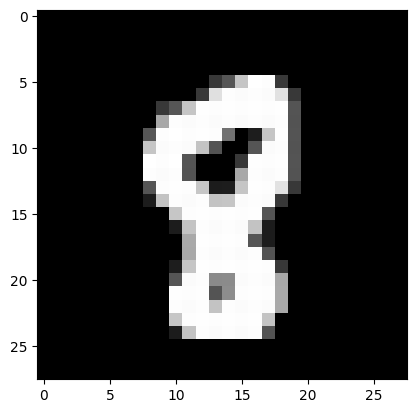

In [54]:
img = batch_images[0].numpy()[0] * 255
img = img.astype(np.uint8)
plt.imshow(img, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[13  5]]
[13  5]


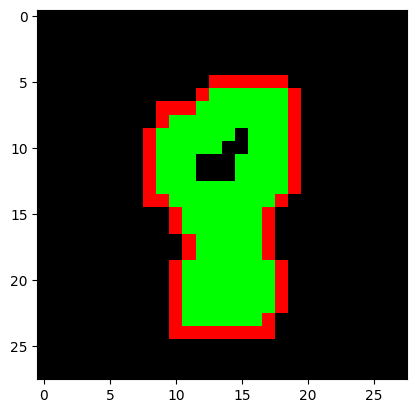

In [72]:
cnt, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cnt = max(cnt, key=cv2.contourArea)

poly = cv2.approxPolyDP(cnt, 0.00054 * cv2.arcLength(cnt, True), True)

print(poly[0])

print(poly.reshape(-1, 2)[0])

out = np.zeros((28,28, 3))
out[:,:, 1] = np.copy(img)
# out = np.copy(img)
# cv2.drawContours(out, poly, -1, 255, 3)
cv2.polylines(out, [poly], True, 255)

plt.imshow(out)